In [1]:
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import pandas as pd
import numpy as np
import scipy.sparse
import shap
import matplotlib as plt
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import BorderlineSMOTE
import lime
from lime import lime_tabular
import statsmodels.api as sm
# from easydl import clear_output
import matplotlib.pyplot as plt
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy import stats
import pingouin as pg
import forestplot as fp
# matplotlib.rcParams['axes.unicode_minus']=False
#plt.rcParams['axes.unicode_minus']=False

In [2]:
def stepwise_selection(X, y,
                       initial_list=[],
                       threshold_in=0.15,
                       threshold_out=0.15,
                       verbose=False):
    included = list(initial_list)

    while True:
        changed = False
        # 前向選擇
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)

        for new_column in excluded:
            try:
                model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit(disp=False)
                new_pval[new_column] = model.pvalues[new_column]
            except:
                continue

        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('新增  {:30}，p-值為 {:.6}'.format(best_feature, best_pval))

        # 反向選擇
        model = sm.Logit(y, sm.add_constant(pd.DataFrame(X[included]))).fit(disp=False)
        pvalues = model.pvalues.iloc[1:]  # 除去截距項
        worst_pval = pvalues.max()

        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()  # 獲取p值最大的特徵名稱
            included.remove(worst_feature)
            if verbose:
                print('移除 {:30}，p-值為 {:.6}'.format(worst_feature, worst_pval))

        if not changed:
            break
    return included

### large intestine Machine Learning

In [3]:
excel_file_path = 'data_clearned.xlsx'
large_intestine_data = pd.read_excel(excel_file_path)

In [4]:
large_intestine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8598 entries, 0 to 8597
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     8598 non-null   int64  
 1   縣市             8598 non-null   object 
 2   簽約租金           8598 non-null   int64  
 3   鄉鎮市區           8598 non-null   object 
 4   出租人年齡          8598 non-null   int64  
 5   建物型態           8598 non-null   object 
 6   屋齡             8598 non-null   int64  
 7   幾房             8598 non-null   int64  
 8   實際使用坪數         8598 non-null   float64
 9   是否為弱勢身分        8598 non-null   int64  
 10  承租人年齡          8598 non-null   int64  
 11  高齡者            8598 non-null   int64  
 12  KMeans_生活型態分群  8598 non-null   int64  
 13  是否電梯大樓         8598 non-null   int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 940.5+ KB


In [5]:
# 排除「是否為弱勢身分」變數，原因如下：
# 依據政策與實務判定，65歲以上高齡者在多數制度設計中已被視為弱勢族群，
# 因此該變數與「高齡身分」高度重疊，易造成多重共線性，亦不利於模型解釋力。
large_intestine_data.drop(['Unnamed: 0','縣市','鄉鎮市區','建物型態','承租人年齡','是否為弱勢身分'], axis=1, inplace=True)
large_intestine_data.dropna(inplace=True)
large_intestine_data.reset_index(drop=True, inplace=True)
large_intestine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8598 entries, 0 to 8597
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   簽約租金           8598 non-null   int64  
 1   出租人年齡          8598 non-null   int64  
 2   屋齡             8598 non-null   int64  
 3   幾房             8598 non-null   int64  
 4   實際使用坪數         8598 non-null   float64
 5   高齡者            8598 non-null   int64  
 6   KMeans_生活型態分群  8598 non-null   int64  
 7   是否電梯大樓         8598 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 537.5 KB


In [6]:
large_intestine_data

,簽約租金,出租人年齡,屋齡,幾房,實際使用坪數,高齡者,KMeans_生活型態分群,是否電梯大樓
0,20349,46,31,4,56.044175,0,2,0
1,20009,49,32,4,56.044175,0,2,0
2,19808,52,36,4,56.044175,0,2,0
3,7990,59,36,4,26.399175,1,2,0
4,9931,35,36,2,29.971700,0,2,0
...,...,...,...,...,...,...,...,...
8593,17960,47,29,2,35.177725,0,2,1
8594,13002,65,36,3,26.822675,0,2,0
8595,16001,49,15,1,21.223400,0,1,1
8596,17997,51,38,2,22.279125,0,2,0


In [7]:
large_intestine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8598 entries, 0 to 8597
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   簽約租金           8598 non-null   int64  
 1   出租人年齡          8598 non-null   int64  
 2   屋齡             8598 non-null   int64  
 3   幾房             8598 non-null   int64  
 4   實際使用坪數         8598 non-null   float64
 5   高齡者            8598 non-null   int64  
 6   KMeans_生活型態分群  8598 non-null   int64  
 7   是否電梯大樓         8598 non-null   int64  
dtypes: float64(1), int64(7)
memory usage: 537.5 KB


In [8]:
large_intestine_data1 = large_intestine_data.copy()

In [9]:
large_intestine_data1

,簽約租金,出租人年齡,屋齡,幾房,實際使用坪數,高齡者,KMeans_生活型態分群,是否電梯大樓
0,20349,46,31,4,56.044175,0,2,0
1,20009,49,32,4,56.044175,0,2,0
2,19808,52,36,4,56.044175,0,2,0
3,7990,59,36,4,26.399175,1,2,0
4,9931,35,36,2,29.971700,0,2,0
...,...,...,...,...,...,...,...,...
8593,17960,47,29,2,35.177725,0,2,1
8594,13002,65,36,3,26.822675,0,2,0
8595,16001,49,15,1,21.223400,0,1,1
8596,17997,51,38,2,22.279125,0,2,0


In [10]:
large_intestine_data1['高齡者'].value_counts()

高齡者
0    8164
1     434
Name: count, dtype: int64

In [11]:
large_intestine_data1.columns

Index(['簽約租金', '出租人年齡', '屋齡', '幾房', '實際使用坪數', '高齡者', 'KMeans_生活型態分群',
       '是否電梯大樓'],
      dtype='object')

#### adenomatous

In [12]:
X = large_intestine_data1.drop(labels=['高齡者'], axis=1)
y = large_intestine_data1['高齡者']

In [13]:
X.columns

Index(['簽約租金', '出租人年齡', '屋齡', '幾房', '實際使用坪數', 'KMeans_生活型態分群', '是否電梯大樓'], dtype='object')

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8598 entries, 0 to 8597
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   簽約租金           8598 non-null   int64  
 1   出租人年齡          8598 non-null   int64  
 2   屋齡             8598 non-null   int64  
 3   幾房             8598 non-null   int64  
 4   實際使用坪數         8598 non-null   float64
 5   KMeans_生活型態分群  8598 non-null   int64  
 6   是否電梯大樓         8598 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 470.3 KB


In [15]:
X = sm.add_constant(X)

model = sm.Logit(y,X).fit_regularized(method='l1', maxiter=500)
    
summary = model.summary()
#view model summary
print(model.summary())
print('-'*80)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.19648659179827158
            Iterations: 44
            Function evaluations: 55
            Gradient evaluations: 44
                           Logit Regression Results                           
Dep. Variable:                    高齡者   No. Observations:                 8598
Model:                          Logit   Df Residuals:                     8590
Method:                           MLE   Df Model:                            7
Date:                Fri, 17 Oct 2025   Pseudo R-squ.:                 0.01716
Time:                        13:23:35   Log-Likelihood:                -1689.4
converged:                       True   LL-Null:                       -1718.9
Covariance Type:            nonrobust   LLR p-value:                 2.403e-10
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [16]:
result = stepwise_selection(X, y)
# clear_output()
X_selected = X[result]
X_selected = sm.add_constant(X_selected)
model = sm.Logit(y, X_selected).fit()

summary = model.summary()
# 查看模型摘要
print(summary)

# 計算 AUC
from sklearn.metrics import roc_auc_score
y_pred_prob = model.predict(X_selected)
auc = roc_auc_score(y, y_pred_prob)
print(f"AUC: {auc:.4f}")

Optimization terminated successfully.
         Current function value: 0.196576
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    高齡者   No. Observations:                 8598
Model:                          Logit   Df Residuals:                     8591
Method:                           MLE   Df Model:                            6
Date:                Fri, 17 Oct 2025   Pseudo R-squ.:                 0.01671
Time:                        13:23:36   Log-Likelihood:                -1690.2
converged:                       True   LL-Null:                       -1718.9
Covariance Type:            nonrobust   LLR p-value:                 1.477e-10
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -4.6142      0.415    -11.116      0.000      -5.428      -3.801
出租人年齡             0.

In [17]:
# 顯示自變量和對應的係數
coef_df = pd.DataFrame({
    'Variable': X_selected.columns,
    'Coefficient': model.params
})
coef_df = coef_df.sort_values(by = 'Coefficient',ascending=False)
print(coef_df)

                    Variable  Coefficient
KMeans_生活型態分群  KMeans_生活型態分群     0.357121
實際使用坪數                實際使用坪數     0.026194
出租人年齡                  出租人年齡     0.014019
屋齡                        屋齡     0.013016
簽約租金                    簽約租金    -0.000038
幾房                        幾房    -0.142051
const                  const    -4.614222


In [18]:
coef_df = coef_df[:-1]

In [19]:
import urllib.request

# 思源黑體 TTF 字體（繁體中文）
url = 'https://github.com/adobe-fonts/source-han-sans/raw/release/OTF/TraditionalChinese/SourceHanSansTC-Regular.otf'
font_path = 'SourceHanSansTC-Regular.otf'

urllib.request.urlretrieve(url, font_path)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(fname='SourceHanSansTC-Regular.otf')

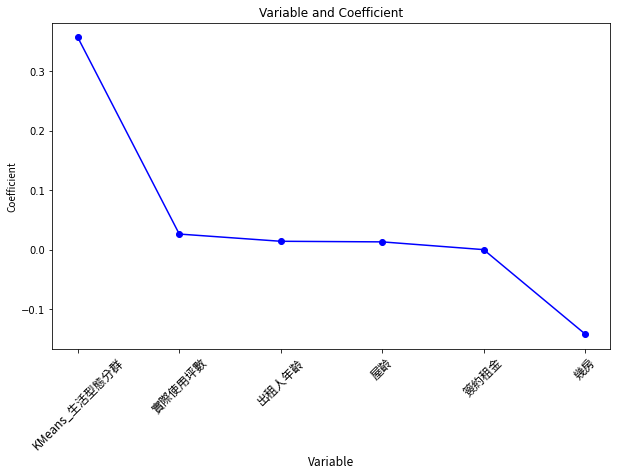

In [20]:
variables = coef_df['Variable']
coefficients = coef_df['Coefficient']

# 載入剛剛下載的字體
font_prop = fm.FontProperties(fname='SourceHanSansTC-Regular.otf')
plt.figure(figsize=(10, 6))
plt.plot(variables, coefficients, marker='o', linestyle='-', color='b')
plt.xlabel('Variable', fontproperties=font_prop, fontsize=12)
plt.ylabel('Coefficient', fontproperties=font_prop)
plt.title('Variable and Coefficient')
plt.xticks(rotation=45, fontproperties=font_prop, fontsize=12)
plt.show()

In [21]:
import numpy as np
import pandas as pd

# 取得係數與標準誤
params = model.params
conf = model.conf_int()  # 信賴區間
conf['OR_lower'] = np.exp(conf[0])
conf['OR_upper'] = np.exp(conf[1])

# Odds Ratio
odds_ratios = np.exp(params)

# 合併成表格
summary_table = pd.DataFrame({
    'Variable': params.index,
    'Coef': params.values,
    'Odds_Ratio': odds_ratios,
    'OR_lower_95CI': conf['OR_lower'],
    'OR_upper_95CI': conf['OR_upper'],
    'p_value': model.pvalues
})

# 輸出結果
pd.set_option('display.float_format', '{:.5f}'.format)
print(summary_table)


                    Variable     Coef  Odds_Ratio  OR_lower_95CI  \
const                  const -4.61422     0.00991        0.00439   
出租人年齡                  出租人年齡  0.01402     1.01412        1.00351   
屋齡                        屋齡  0.01302     1.01310        1.00045   
實際使用坪數                實際使用坪數  0.02619     1.02654        1.01654   
幾房                        幾房 -0.14205     0.86758        0.76152   
KMeans_生活型態分群  KMeans_生活型態分群  0.35712     1.42921        1.11454   
簽約租金                    簽約租金 -0.00004     0.99996        0.99993   

               OR_upper_95CI  p_value  
const                0.02236  0.00000  
出租人年齡                1.02483  0.00895  
屋齡                   1.02591  0.04236  
實際使用坪數               1.03664  0.00000  
幾房                   0.98841  0.03275  
KMeans_生活型態分群        1.83272  0.00488  
簽約租金                 0.99999  0.00875  


In [22]:
#轉存excel
file_name = "Odd_Ratio.xlsx"
# saving the excelsheet
summary_table.to_excel(file_name)

### probability

In [23]:
#A = list(df_with_dummies[df_with_dummies['calculate'] == 0]['probabilities'].values)
B = list(df_with_dummies[df_with_dummies['calculate'] == 0.5]['probabilities'].values)
C = list(df_with_dummies[df_with_dummies['calculate'] == 1]['probabilities'].values)
D = list(df_with_dummies[df_with_dummies['calculate'] == 1.5]['probabilities'].values)
E = list(df_with_dummies[df_with_dummies['calculate'] == 2]['probabilities'].values)
F = list(df_with_dummies[df_with_dummies['calculate'] == 2.5]['probabilities'].values)
G = list(df_with_dummies[df_with_dummies['calculate'] == 3]['probabilities'].values)
H = list(df_with_dummies[df_with_dummies['calculate'] == 3.5]['probabilities'].values)

NameError: name 'df_with_dummies' is not defined

In [ ]:
statistic, p_value=levene( B, C, D, E, F, G, H)
print('statistic:%.2f'%statistic)
print('p_value:%.2f'%p_value)

In [ ]:
f_statistic, p_value = f_oneway(A, B, C, D, E, F, G, H)
print("f_statistic:%.2f"%f_statistic)
print("p_value:%.2f"%p_value)

In [ ]:
posthoc = stats.tukey_hsd(A, B, C, D, E, F, G, H)
print(posthoc)

### odds ratio

In [ ]:
A = list(df_with_dummies[df_with_dummies['calculate'] == 0]['odds ratio'].values)
B = list(df_with_dummies[df_with_dummies['calculate'] == 0.5]['odds ratio'].values)
C = list(df_with_dummies[df_with_dummies['calculate'] == 1]['odds ratio'].values)
D = list(df_with_dummies[df_with_dummies['calculate'] == 1.5]['odds ratio'].values)
E = list(df_with_dummies[df_with_dummies['calculate'] == 2]['odds ratio'].values)
F = list(df_with_dummies[df_with_dummies['calculate'] == 2.5]['odds ratio'].values)
G = list(df_with_dummies[df_with_dummies['calculate'] == 3]['odds ratio'].values)
H = list(df_with_dummies[df_with_dummies['calculate'] == 3.5]['odds ratio'].values)

In [ ]:
statistic, p_value=levene(A, B, C, D, E, F, G, H)
print('statistic:%.2f'%statistic)
print('p_value:%.2f'%p_value)

In [ ]:
f_statistic, p_value = f_oneway(A, B, C, D, E, F, G, H)
print("f_statistic:%.2f"%f_statistic)
print("p_value:%.2f"%p_value)

In [ ]:
posthoc = stats.tukey_hsd(A, B, C, D, E, F, G, H)
print(posthoc)

In [ ]:
A = list(df_with_dummies[df_with_dummies['group'] == 0]['probabilities'].values)
B = list(df_with_dummies[df_with_dummies['group'] == 1]['probabilities'].values)
C = list(df_with_dummies[df_with_dummies['group'] == 2]['probabilities'].values)

In [ ]:
statistic, p_value = levene(A, B, C)
print('statistic:%.2f'%statistic)
print('p_value:%.2f'%p_value)

In [ ]:
scores = A + B + C
groups = ['A'] * len(A) + ['B'] * len(B) + ['C'] * len(C)

data = pd.DataFrame({'組別': groups, '分數': scores})
pg.welch_anova(dv='分數', between='組別', data=data)

In [ ]:
results = pg.pairwise_gameshowell(dv='分數', between='組別', data=data)
results

In [ ]:
# filtered_df = pg.pairwise_gameshowell(dv='分數', between='組別', data=data)
# 計算95%區間
results['CI Low'] = results['diff'] - 1.96 * results['se']
results['CI High'] = results['diff'] + 1.96 * results['se']

# 均值差異
comparisons = results['A'] + ' - ' + results['B']
mean_diff = results['diff']
ci_low = results['CI Low']
ci_high = results['CI High']

In [ ]:
plt.figure(figsize=(8, 6))

# 先繪製折線圖並連線
plt.plot(comparisons, mean_diff, marker='o', linestyle='-', color='blue', label='Mean Difference')

# 再繪製誤差區間
plt.errorbar(comparisons, mean_diff, yerr=[mean_diff - ci_low, ci_high - mean_diff], fmt='o', color='blue', ecolor='blue', capsize=5)

plt.xticks(rotation=45, ha='right')  # 設置X軸旋轉 旋轉45度
plt.ylabel('Mean Difference')
plt.xlabel('Comparisons')
plt.title('Differences of Means for Strength')

plt.tight_layout()
plt.savefig('Differences of Means(probabilities).png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
filtered_df = results[
    ((results['A'] == 'A') & (results['B'] == 'B')) |
    ((results['A'] == 'A') & (results['B'] == 'C')) |
    ((results['A'] == 'B') & (results['B'] == 'C'))]
filtered_df = filtered_df.sort_values(by='diff', ascending=True)

In [ ]:
filtered_df['diff'] = filtered_df['diff'].abs()

In [ ]:
filtered_df = filtered_df.sort_values(by='diff', ascending=True)

In [ ]:
# filtered_df = pg.pairwise_gameshowell(dv='分數', between='組別', data=data)
# 計算95%區間
filtered_df['CI Low'] = filtered_df['diff'] - 1.96 * results['se']
filtered_df['CI High'] = filtered_df['diff'] + 1.96 * results['se']

# 均值差異
comparisons = filtered_df['A'] + ' - ' + filtered_df['B']
mean_diff = filtered_df['diff']
ci_low = filtered_df['CI Low']
ci_high = filtered_df['CI High']

In [ ]:
plt.figure(figsize=(8, 6))

# 先繪製折線圖並連線
plt.plot(comparisons, mean_diff, marker='o', linestyle='-', color='blue', label='Mean Difference')

# 再繪製誤差區間
plt.errorbar(comparisons, mean_diff, yerr=[mean_diff - ci_low, ci_high - mean_diff], fmt='o', color='blue', ecolor='blue', capsize=5)

plt.xticks(rotation=45, ha='right')  # 設置X軸旋轉 旋轉45度
plt.ylabel('Mean Difference')
plt.xlabel('Comparisons')
plt.title('Differences of Means for Strength')

plt.tight_layout()
plt.savefig('Differences of Means(probabilities).png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# A = list(df_with_dummies[df_with_dummies['calculate'] == 0]['odds ratio'].values)
B = list(df_with_dummies[df_with_dummies['calculate'] == 0.5]['odds ratio'].values)
C = list(df_with_dummies[df_with_dummies['calculate'] == 1]['odds ratio'].values)
D = list(df_with_dummies[df_with_dummies['calculate'] == 1.5]['odds ratio'].values)
E = list(df_with_dummies[df_with_dummies['calculate'] == 2]['odds ratio'].values)
F = list(df_with_dummies[df_with_dummies['calculate'] == 2.5]['odds ratio'].values)
G = list(df_with_dummies[df_with_dummies['calculate'] == 3]['odds ratio'].values)
H = list(df_with_dummies[df_with_dummies['calculate'] == 3.5]['odds ratio'].values)

In [ ]:
statistic, p_value = levene(B, C, D, E, F, G, H)
print('statistic:%.2f'%statistic)
print('p_value:%.2f'%p_value)

In [ ]:
scores = B + C + D + E + F + G + H
groups = ['B'] * len(B) + ['C'] * len(C) + ['D'] * len(D) + ['E'] * len(E) + ['F'] * len(F) + ['G'] * len(G) + ['H'] * len(H)  # 创建对应的班级标签

data = pd.DataFrame({'組別': groups, '分數': scores})
pg.welch_anova(dv='分數', between='組別', data=data)

In [ ]:
results = pg.pairwise_gameshowell(dv='分數', between='組別', data=data)
results

In [ ]:
filtered_df = results[
    ((results['A'] == 'B') & (results['B'] == 'C')) |
    ((results['A'] == 'C') & (results['B'] == 'D')) |
    ((results['A'] == 'D') & (results['B'] == 'E')) |
    ((results['A'] == 'E') & (results['B'] == 'F')) |
    ((results['A'] == 'F') & (results['B'] == 'G')) |
    ((results['A'] == 'G') & (results['B'] == 'H'))
]
filtered_df = filtered_df.sort_values(by='diff', ascending=True)

In [ ]:
filtered_df

In [ ]:
# filtered_df = pg.pairwise_gameshowell(dv='分數', between='組別', data=data)
# 計算95%區間
filtered_df['CI Low'] = filtered_df['diff'] - 1.96 * results['se']
filtered_df['CI High'] = filtered_df['diff'] + 1.96 * results['se']

# 均值差異
comparisons = filtered_df['A'] + ' - ' + filtered_df['B']
mean_diff = filtered_df['diff']
ci_low = filtered_df['CI Low']
ci_high = filtered_df['CI High']

In [ ]:
plt.figure(figsize=(8, 6))

# 先繪製折線圖並連線
plt.plot(comparisons, mean_diff, marker='o', linestyle='-', color='blue', label='Mean Difference')

# 再繪製誤差區間
plt.errorbar(comparisons, mean_diff, yerr=[mean_diff - ci_low, ci_high - mean_diff], fmt='o', color='blue', ecolor='blue', capsize=5)

plt.xticks(rotation=45, ha='right')  # 設置X軸旋轉 旋轉45度
plt.ylabel('Mean Difference')
plt.xlabel('Comparisons')
plt.title('Differences of Means for Strength')

plt.tight_layout()
plt.savefig('Differences of Means(Odds ratio).png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
A = list(df_with_dummies[df_with_dummies['calculate'] == 0]['odds ratio'].values)
B = list(df_with_dummies[df_with_dummies['calculate'] == 0.5]['odds ratio'].values)
C = list(df_with_dummies[df_with_dummies['calculate'] == 1]['odds ratio'].values)
C = list(df_with_dummies[df_with_dummies['calculate'] == 1.5]['odds ratio'].values)
D = list(df_with_dummies[df_with_dummies['calculate'] == 2]['odds ratio'].values)
E = list(df_with_dummies[df_with_dummies['calculate'] == 2.5]['odds ratio'].values)
F = list(df_with_dummies[df_with_dummies['calculate'] == 3]['odds ratio'].values)
F = list(df_with_dummies[df_with_dummies['calculate'] == 3.5]['odds ratio'].values)

In [ ]:
statistic, p_value = levene(B, C, D, E, F)
print('statistic:%.2f'%statistic)
print('p_value:%.2f'%p_value)

In [ ]:
scores = B + C + D + E + F
groups = ['B'] * len(B) + ['C'] * len(C) + ['D'] * len(D) + ['E'] * len(E) + ['F'] * len(F)  # 创建对应的班级标签

data = pd.DataFrame({'組別': groups, '分數': scores})
pg.welch_anova(dv='分數', between='組別', data=data)

In [ ]:
results = pg.pairwise_gameshowell(dv='分數', between='組別', data=data)
results

In [ ]:
filtered_df = results[
    ((results['A'] == 'B') & (results['B'] == 'C')) |
    ((results['A'] == 'C') & (results['B'] == 'D')) |
    ((results['A'] == 'D') & (results['B'] == 'E')) |
    ((results['A'] == 'E') & (results['B'] == 'F')) |
    ((results['A'] == 'F') & (results['B'] == 'G')) |
    ((results['A'] == 'G') & (results['B'] == 'H'))
]
filtered_df = filtered_df.sort_values(by='diff', ascending=True)
filtered_df

In [ ]:
filtered_df['diff'] = filtered_df['diff'].abs()
filtered_df

In [ ]:
filtered_df = filtered_df.sort_values(by='diff', ascending=True)
filtered_df

In [ ]:
# 計算95%區間
filtered_df['CI Low'] = filtered_df['diff'] - 1.96 * filtered_df['se']
filtered_df['CI High'] = filtered_df['diff'] + 1.96 * filtered_df['se']

# 均值差異
comparisons = filtered_df['A'] + ' - ' + filtered_df['B']
mean_diff = filtered_df['diff']
ci_low = filtered_df['CI Low']
ci_high = filtered_df['CI High']

In [ ]:
plt.figure(figsize=(8, 6))

# 先繪製折線圖並連線
plt.plot(comparisons, mean_diff, marker='o', linestyle='-', color='blue', label='Mean Difference')

# 再繪製誤差區間
plt.errorbar(comparisons, mean_diff, yerr=[mean_diff - ci_low, ci_high - mean_diff], fmt='o', color='blue', ecolor='blue', capsize=5)

plt.xticks(rotation=45, ha='right')  # 設置X軸旋轉 旋轉45度
plt.ylabel('Mean Difference')
plt.xlabel('Comparisons')
plt.title('Differences of Means for Strength')

plt.tight_layout()
plt.savefig('Differences of Means(Odds ratio).png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def calculate_group(row):
  
    if row['calculate'] <= -3.10:
        group = 0
    else:
        group = 1
        
    return group

df_with_dummies['group'] = df_with_dummies.apply(calculate_group, axis=1)

In [ ]:
predicted_probabilities = model.predict(X_selected)
df_with_dummies['probabilities'] = predicted_probabilities
df_with_dummies['odds ratio'] = df_with_dummies['probabilities'] / (1 - df_with_dummies['probabilities'])
df_with_dummies

In [ ]:
from scipy.stats import levene

group0 = df_with_dummies[df_with_dummies['group'] == 0]
group1 = df_with_dummies[df_with_dummies['group'] == 1]

statistic, p_value = levene(group0['probabilities'], group1['probabilities'])

print(f'statistic: {statistic:.2f}')
print(f'p_value: {p_value:.2f}')

if p_value > 0.05:
    print("✅ 不顯著 ➝ 使用 Tukey HSD")
else:
    print("❗ 顯著 ➝ 使用 Welch ANOVA")


In [ ]:
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(group0['probabilities'], group1['probabilities'], equal_var=False, alternative='two-sided')
print(f"Welch t-test: t = {t_stat:.4f}, p = {p_value:.4f}")


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=data, x='group', y='probabilities')
sns.stripplot(data=data, x='group', y='probabilities', color='black', alpha=0.3)
plt.title('Group Comparison of Probabilities')
plt.show()

In [ ]:
group0['probabilities'] += np.random.normal(0, 1e-10, size=group0.shape[0])

In [ ]:
import pingouin as pg
import pandas as pd

# 建立分析用資料集
data = pd.concat([
    group0[['probabilities']].assign(group='low'),
    group1[['probabilities']].assign(group='high')
])

# 執行 Welch ANOVA
result = pg.welch_anova(dv='probabilities', between='group', data=data)
print(result)


In [ ]:
results = pg.pairwise_gameshowell(dv='probabilities', between='group', data=data)
print(results)


In [ ]:
from scipy.stats import ttest_ind,t
t_statistic, p_value = ttest_ind(group0['probabilities'], group1['probabilities'], equal_var=False, alternative='two-sided')
formatted_p_value = format(p_value, '.3f')

print(f"P value for group0 {'probabilities'} vs group1 {'probabilities'}: {formatted_p_value}")

In [ ]:
def calculate_group(row):
    # NHHR = (row['Total_Cholesterol'] - row['HDL'])/row['HDL']
    
    if row['calculate'] <= -3.10:
        group = 0
    else:
        group = 1
        
    return group

df_with_dummies['group'] = df_with_dummies.apply(calculate_group, axis=1)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10))

x = sorted(df_with_dummies['group'].value_counts().index)

h = []

h_a1 = []

for i in x:
    total_count = df_with_dummies['group'].value_counts()[i] 
    a1_count = df_with_dummies[(df_with_dummies['group'] == i) & (df_with_dummies['Gallstones'] == 1)].shape[0]
    h.append(total_count)
    h_a1.append(a1_count)

bars = plt.bar(x, h, width=0.05, label='Total')
bars_a1 = plt.bar(x, h_a1, width=0.05, label='IM(1)', alpha=0.7, color='orange')

for bar, a1_count in zip(bars, h_a1):
    yval = bar.get_height()  
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f"{int(yval)}\n({a1_count})", ha='center', va='bottom', fontsize=10)

plt.legend(fontsize=12)
plt.xlabel('group', fontsize=14)
plt.ylabel('Count', fontsize=14)
# plt.title('Total Count and adenoma == 1 Count per Calculate', fontsize=16)

# 儲存圖片
# plt.savefig('ANOVA_Smoking.png', dpi=300)

# 顯示圖表
plt.show()

In [ ]:
X = df_with_dummies[['calculate']]
y = df_with_dummies[['Gallstones']]

In [ ]:
import statsmodels.api as sm
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

In [ ]:
X = sm.add_constant(X)
model = sm.Logit(y, X).fit()

print(model.summary())
print('-' * 80)

y_pred = model.predict(X)

fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 基線
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
TP = len(df_with_dummies[(df_with_dummies['group'] == 1) & (df_with_dummies['Gallstones'] == 1)])
FP = len(df_with_dummies[(df_with_dummies['group'] == 1) & (df_with_dummies['Gallstones'] == 0)])
FN = len(df_with_dummies[(df_with_dummies['group'] == 0) & (df_with_dummies['Gallstones'] == 1)])
TN = len(df_with_dummies[(df_with_dummies['group'] == 0) & (df_with_dummies['Gallstones'] == 0)])
print(f'診斷得病/陽性：{TP}')
print(f'診斷得病/陰性：{FP}')
print(f'診斷未得病/陽性：{FN}')
print(f'診斷未得病/陰性：{TN}')
print('-'*40)
#（High risk with disease）
PPV = round(len(df_with_dummies[(df_with_dummies['group'] == 1) & (df_with_dummies['Gallstones'] == 1)])/len(df_with_dummies[(df_with_dummies['group'] == 1)]),3)

#（Low risk without disease）
NPV = round(len(df_with_dummies[(df_with_dummies['group'] == 0) & (df_with_dummies['Gallstones'] == 0)])/len(df_with_dummies[(df_with_dummies['group'] == 0)]),3)

print(f'高風險有患病：{PPV}')
print(f'低風險無患病：{NPV}')
print('-'*40)
prevalence = round((TP + FN)/(TP + FP + FN + TN),3)
print(f'疾病盛行率：{prevalence}')
print(f'沒得病機率：{1 - prevalence}')
print('-'*40)
print(f'如果診斷後顯示為陽性 ( 診斷得病 ) ，則此人得病的機率從{prevalence}上升為{PPV}')
print(f'如果診斷後顯示為陰性 ( 診斷沒得病 )，則此人沒得病的機率從{1-prevalence}上升為{NPV}')